<a href="https://colab.research.google.com/github/AminaTkh/AlanTuringInstitute_Bias_in_AI_Beyond_Binary_Classification/blob/main/ClusteringMeasuringBiasExercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Measuring Bias in a Clustering Model

In this notebook, we audit a clustering model for bias using the holisticai library. We will load and explore a dataset, train a model, and audit it using the library's bias metrics. All questions and tasks are bolded and in red.

### 0 - Importing modules and loading the data

We begin by loading the dataset. For this milestone, we will be using the 'Adult Data Set' from the UC Irvine Machine Learning Repository and loading it directly from the holisticai library. The dataset contains information extracted from the US 1994 Census database and is used to predict whether a person's annual income exceeds $50,000. In this tutorial we will perform unsupervised learning to cluster the data, then measure whether the clusters contain gender or race information (clustering bias).

In [1]:
# make sure you have holisticai library installed
!pip install holisticai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 37.9 MB/s eta 0:00:00


In [2]:
# Base Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# import dataset
from holisticai.datasets import load_adult

# import plotting functions
from holisticai.bias.plots import group_pie_plot
from holisticai.bias.plots import histogram_plot
from holisticai.bias.plots import frequency_matrix_plot

# import some bias metrics
from holisticai.bias.metrics import cluster_balance
from holisticai.bias.metrics import min_cluster_ratio
from holisticai.bias.metrics import clustering_bias_metrics

In [3]:
# load dataset into a dataframe
df = load_adult()['frame']

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


### 1- Exploring the dataset

Now that we've loaded the data, let's explore it using pandas.

In [4]:
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27.0,Private,257302.0,Assoc-acdm,12.0,Married-civ-spouse,Tech-support,Wife,White,Female,0.0,0.0,38.0,United-States,<=50K
48838,40.0,Private,154374.0,HS-grad,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
48839,58.0,Private,151910.0,HS-grad,9.0,Widowed,Adm-clerical,Unmarried,White,Female,0.0,0.0,40.0,United-States,<=50K
48840,22.0,Private,201490.0,HS-grad,9.0,Never-married,Adm-clerical,Own-child,White,Male,0.0,0.0,20.0,United-States,<=50K


In [5]:
df.columns.values

array(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'class'], dtype=object)

From the previous two cells, we see that the dataset is quite large with 48842 entries and 15 attributes. There are several sensitive attributes in the data including 'age', 'race', and 'sex'. The last attribute tracks whether or not a person earns more than $50,000 annually. Let's explore the distribution of the data amongst these various attributes.

<Axes: xlabel='race', ylabel='Probability'>

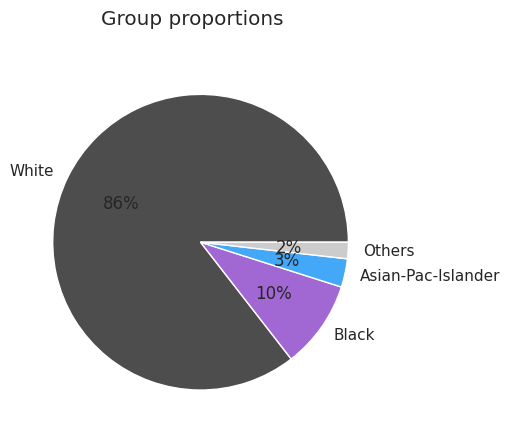

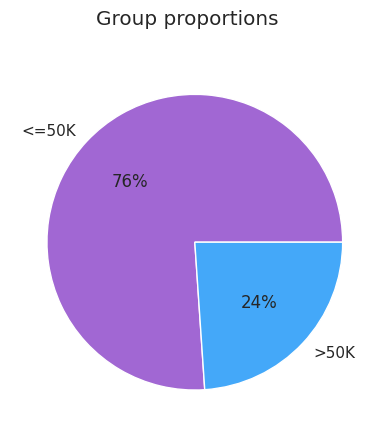

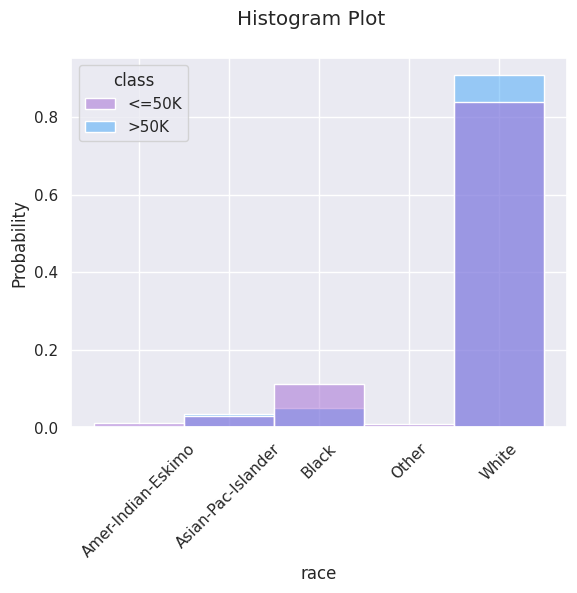

In [6]:
# pie plot of race column
p_attr = df['race']
group_pie_plot(p_attr)

# pie plot of class column
p_attr = df['class']
group_pie_plot(p_attr)

# Histogram of race with class as hue
histogram_plot(df['race'], df['class'])

The pie chart above shows the distribution of various races in the data. We see that the data is very unbalanced having 86% of people in the census calssified as White. If we compare the break down the 'class' attribute with 'race', we see that more White people make over $50,000 than make lesss, while the opposite is true for other races.

<font color='red'>  **Task 1**
- **Create a pie plot for the 'sex' attribute and a histogram of 'sex' and 'class'**
<font >

<Axes: xlabel='sex', ylabel='Probability'>

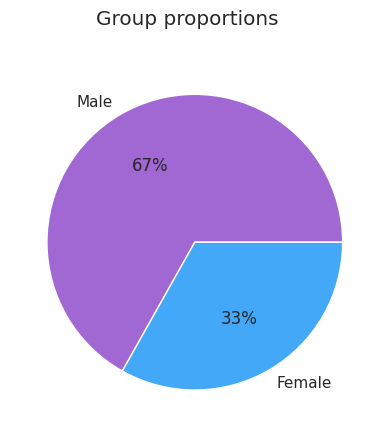

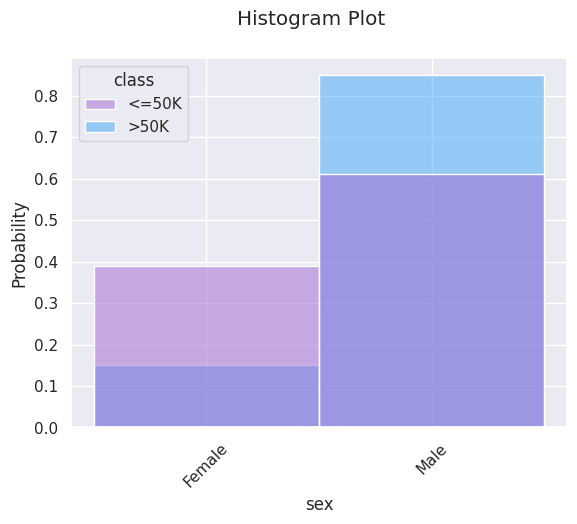

In [7]:
# pie plot of race column

group_pie_plot(df['sex'])

# histogram of sex with class as hue

histogram_plot(df['sex'], df['class'])

From the pie chart, you should see that there double the amount of Males than Females.

### 2 - Pre-processing the data and training the model

In this next section, we are going to prepare the data for clustering. We will use sklearn's k-means clustering as our model of choice, and we use its train_test_split function to split our dataset. Note, we do not want to include protected attributes in the training so we will remove 'sex', and 'race' from the features during training and inference. After training, we will evaluate the model's performance overall and then audit it for bias.

In [8]:
# Dataset
dataset = load_adult()

# Dataframe
df = pd.concat([dataset["data"], dataset["target"]], axis=1)
protected_variables = ["sex", "race"]
output_variable = ["class"]

# Simple preprocessing
y = df[output_variable].replace({">50K": 1, "<=50K": 0}) # replace the target with binary outputs
X = pd.get_dummies(df.drop(protected_variables + output_variable, axis=1)) # remove protected attributes and target variable for training


# Train test split
data = [X, y]#, group_a, group_b]
dataset = train_test_split(*data, test_size=0.2, shuffle=True, random_state=42)
train_data = dataset[::2]
test_data = dataset[1::2]



/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Now that we've prepared the data, we will train several k-means clustering models. The reason for training multiple models is to figure out the optimal number of clusters. We can measure this by calculating 'inertia' by measuring the distance between each data point and its cluster center and taking the sum of squares of each distance. A good clustering model will have low inertia *and* a small number of clusters, however, as $k$ increases, inertia decreases. To find the optimal $k$, we look for the point where the decrease in inertia begins to diminish, also known as the 'elbow'. In this case, our optimal number of clusters is $k = 4$.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

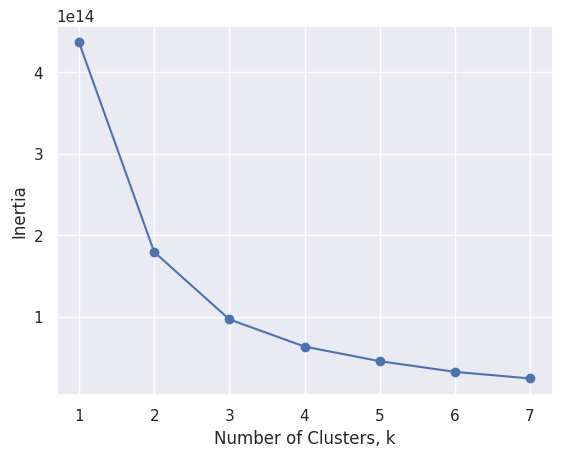

In [9]:
# test different k to create a graph for inertia and choose best model
ks = range(1, 8)
inertias = []
X_train, _ = train_data

for k in ks:
    # create a KMeans instance with k clusters: model
    model = KMeans(n_clusters = k)

    # fit model to samples
    model.fit(X_train)

    # append the inertia to the list of inertias
    inertias.append(model.inertia_)

# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of Clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()


In [10]:
# we choose to use 4 clusters
model = KMeans(n_clusters = 4)
model.fit(X_train)

# test data
X, _ = test_data

# predict
y_pred = model.predict(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### 3 - Measuring bias
In this section, we will audit our model for bias using a number of metrics. We will investigate bias with respect to two protected attributes: 'sex' and 'race'. We use the test set to perform our audit.

<Axes: xlabel='Class', ylabel='Group'>

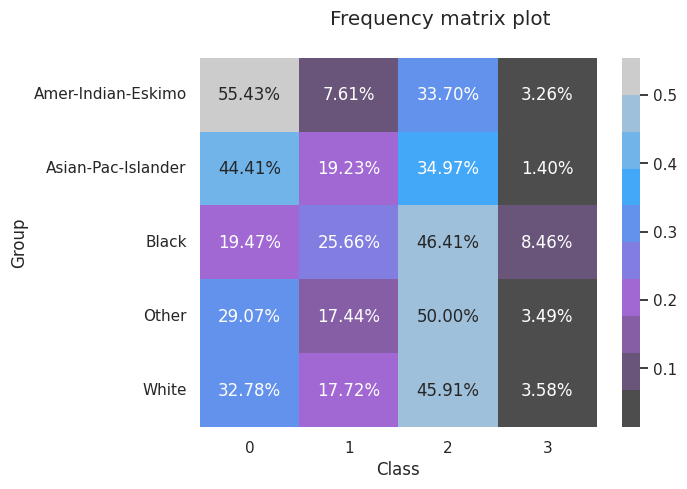

In [11]:
# set up vectors for measuring bias
p_attr_race = df.iloc[X.index]['race']
y_pred = model.predict(X)

# probability for each race and group
frequency_matrix_plot(p_attr_race, y_pred, normalize='group')

In terms of race representations, some clusters are quite unbalanced. The k-means model has learned some form of implicit Race information from the data. Moreover, the features in the data set can be used as proxies to 'race'. Depending on the application of interest, this bias may be an issue. Let's explore some of the bias metrics for clustering using the holistiai library.

We will first look at the cluster balance between the 'White' and 'Amer-Indian-Eskimo' groups. The goal of the cluster_balance function is to determine if members of a particular group are under represented in a given cluster. For each cluster, we find the proportion of members from each group that have been assigned to it, and divide it by the proportion of each group in the entirety of the data. Another way of looking at it is we find the fraction of each group assigned to that cluster and divde by the fraction of the whole data set assigned to that cluster. The function will return the minimum cluster ratio out of both groups. The ideal value for this metrics is 1.

From the frequency matrix plot we may suspect there to be a cluster imbalance in the 4th as there is a very small percentage of members of the 'Amer-Indian-Eskimo' group. We confirm this in the cell below.


In [12]:
group_a = p_attr_race=='Amer-Indian-Eskimo'
group_b = p_attr_race=='White'
print('Amer-Indian-Eskimo/White Cluster Balance:', np.round(cluster_balance(group_a, group_b, y_pred),5))

Amer-Indian-Eskimo/White Cluster Balance: 0.41134


From this metric, we have reason to believe that there is an underrepresentation in the clusters due to the metric being significantly smaller than 1. We can probe further by looking at the Minimum Cluster Ratio. The min_cluster_ratio function will compare the proportions of each group in a cluster, and return the smallest ratio. Values close to 1 indicate that the clusters are relatively balanced while values below 1 represent an underrepresentation of group a and values over 1 represent an underrepresentation of group b. The cell below shows a clear underrepresentation of the 'Amer-Indian-Eskimo' group with the minumum ratio being nearly 0.

In [13]:
group_a = p_attr_race=='Amer-Indian-Eskimo'
group_b = p_attr_race=='White'
print('Amer-Indian-Eskimo/White Minimum Cluster Ratio:', np.round(min_cluster_ratio(group_a, group_b, y_pred),5))

Amer-Indian-Eskimo/White Minimum Cluster Ratio: 0.00477


We can examine a few more metrics for clustering using the clustering_bias_metrics function that fall under Equality of Outcome. It will produce the two above as well as Cluster Distribution Total Variation, Cluster Distribution KL Divergence, Social Fairness Ratio, and Silhouette Difference. Let's break down these other metrics and then calculate them below.

Cluster Distribution Total Variation computes the distribution of group_a and group_b across clusters and then outputs the total variation distance between these distributions. Ideally this metric should have a value of 0.

Cluster Distribution Total Variation It then returns the KL distance from the distribution of group_a to the distribution of group_b. The KL divergence of two distributions $p$ and $q$ is defined as: $KL(P||Q)=\sum_{x}P(x)\log(\frac{P(x)}{Q(x)})$. Here the ideal value is also 0, the goal is to have similar distributions for both groups.

Social Fairness Ratio computes the average of the distance to the nearest centroid for each point in both groups and takes the ratio of the averages.
Considering each cluster centroid, Social Fairness Ratio computes the distance between every point and its nearest centroid. Then for each group, these distances are averaged and the the ratio of the average distance to the nearest centroid for each group is taken. The ideal value for this metric is 1, as the average distance between centroids and groups should be the same.

The final metric in the equal outcome metrics is the Silhouette Difference. The Silhouette Coefficient are a goodness of clustering measurement with values in the range of [-1,1]. For values near 1, the clusters are well apart from each other and are clear distinguished. For values near 0, the distance between clusters are insignificant. For values near -1, the clusters are assigne in the wrong way. We can measure bias with these values: the silhouette difference ranges from -1 to 1, with lower values indicating bias towards group_a and larger values indicating bias against group_b.

In [14]:
centroids = model.cluster_centers_
data = X.to_numpy()
clustering_bias_metrics(group_a, group_b, y_pred, data = data, centroids = centroids, metric_type = 'equal_outcome')

,Value,Reference
Metric,,
Cluster Balance,0.411341,1
Minimum Cluster Ratio,0.004765,1
Cluster Distribution Total Variation,0.226524,0
Cluster Distribution KL Div,0.119565,0
Social Fairness Ratio,1.225273,1
Silhouette Difference,0.000701,0


<font color='red'>  **Task 2**
- **Generate a frequency matrix plot and calculate the equal outcome metrics for clustering using 'sex' as the protected attribute.**
<font >

,Value,Reference
Metric,,
Cluster Balance,0.808746,1
Minimum Cluster Ratio,0.369338,1
Cluster Distribution Total Variation,0.032563,0
Cluster Distribution KL Div,0.003564,0
Social Fairness Ratio,0.947046,1
Silhouette Difference,0.004578,0


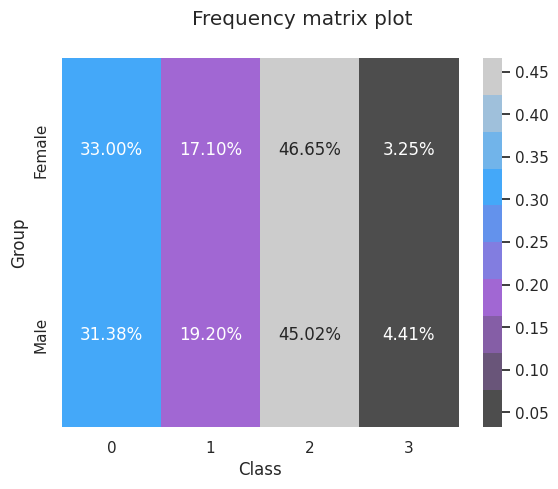

In [15]:
p_attr_sex = df.iloc[X.index]['sex']
# probability for each gender and class
frequency_matrix_plot(p_attr_sex, y_pred, normalize='group')

# set up data arrays
group_a = p_attr_sex=='Female'
group_b = p_attr_sex=='Male'
y_pred = y_pred
centroids = model.cluster_centers_
data = X.to_numpy()

clustering_bias_metrics(group_a, group_b, y_pred, data = data, centroids = centroids, metric_type = 'equal_outcome')


You should get the following results:

| Metric | Value | Reference |
| --- | --- | --- |
| Cluster Balance | 0.808746 | 1 |
| Minimum Cluster Ratio   | 0.369338 | 1 |
| Cluster Distribution Total Variation          | 0.032563 | 0 |
| Cluster Distribution KL Div         | 0.003564 | 0 |
| Social Fairness Ratio         | 0.947046 | 1 |
| Silhouette Difference         | 0.004578 | 0 |


